# ROIC performance analysis

### Main Tasks

1. ROIC の Point to Point でのパフォーマンス（クロス表）
    - リターンの期間を 1month ではなく ROIC の期間(3 or 5 years)に合わせる
    - セルごとの銘柄数カウント
    - 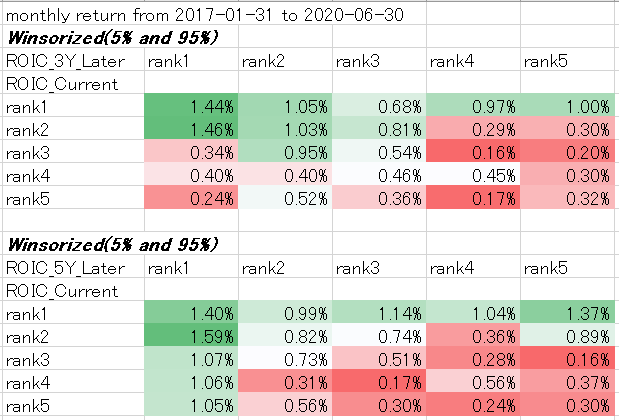
    - 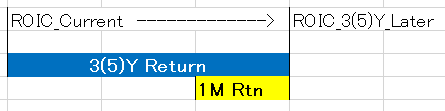
2. 高 ROIC 維持率(銘柄群のリストアップ)
3. 将来 ROIC Label 計測期間について, 1~2 年のランクを歯抜けにしたパターンでラベリングする
    - ROIC の短期予測に依存せず, 長期のみを見ていればよいことの証左になるか？
4. リターンの計測期間
    - 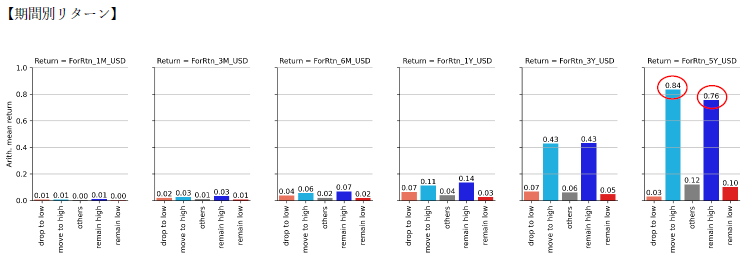

### Goals

-   メンバーにシェア
-   ピッチブック掲載
-   ROIC が落ちそうな銘柄の warnings, watch
    -   これは今後のクオンツ分析で挑戦
-   セクター別の高 ROIC label 回転率
    -   セクター依存性があるため(cyclical)

### Others

-   ROIC 計測期間: 3 年も refer


In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.ticker as mtick
from pprint import pprint
from database_utils import DBHandler
from ROIC_make_data_files import (
    get_constituents_weight_from_factset,
    get_id_and_return_from_factset,
    merge_weight_and_roic,
    add_forward_return_cols,
    add_past_and_forward_roic_cols_quarter,
    add_shifted_roic_cols_month,
    add_roic_rank_cols,
    calculate_roic_slope_quarter,
    calculate_roic_slope_month,
    # assign_roic_label,
    test_assign_roic_label,
    clipped_mean,
    clipped_std,
    plot_period_return,
    plot_sankey_diagram,
    calculate_cumulative_return,
    plot_roic_label_cum_return,
    make_roic_label_and_performance_table,
    performance_color_cells,
    calculate_winsorized_mean,
)
import warnings

warnings.simplefilter("ignore")

ROOT_DIR = Path().cwd().parent
DATA_DIR = ROOT_DIR / "data_analysis#02"
print(DATA_DIR)


h:\HataY\03_Work\15_Quant\02_ROIC\data_analysis#02


# Preparing ROIC label and Return data


In [ ]:
file_list = [
    DATA_DIR / "MSCI KOKUSAI_20050429_20150331.xlsx",
    DATA_DIR / "MSCI KOKUSAI_20150430_20250331.xlsx",
    DATA_DIR / "MSCI KOKUSAI_20250430_20250630.xlsx",
]

get_constituents_weight_from_factset(file_list=file_list)
get_id_and_return_from_factset(excel_file=DATA_DIR / "D_get_ROIC2.xlsx")
df = (
    merge_weight_and_roic()
    .pipe(add_forward_return_cols)  # 将来リターンのカラムを追加
    .pipe(
        add_shifted_roic_cols_month, shift_direction="both"
    )  # 将来・過去ROICのカラムを追加
    .pipe(add_roic_rank_cols, freq_suffix="M")  # ROICのRankカラムを追加
)
df.to_parquet(DATA_DIR / "temp.parquet")


df_to_merge = df.copy()
# calculate ROIC slope1
roic_cols = ["ROIC"] + [
    col
    for col in df.columns
    if ("ROIC" in col) and ("Forward" in col) and ("Rank" not in col)
]
df["ROIC_Slope_36MForward"] = df.apply(
    lambda x: calculate_roic_slope_month(x, 36), axis=1
)
df["ROIC_Slope_60MForward"] = df.apply(
    lambda x: calculate_roic_slope_month(x, 60), axis=1
)


# ROIC Rankチェック頻度: 年次(ann)
df_to_merge["ROIC_Label_ann_3YForward"] = df.apply(
    test_assign_roic_label, freq="annual", year_period=3, judge_by_slope=True, axis=1
)
# ROIC Rankチェック頻度: 月次(mon)
df_to_merge["ROIC_Label_mon_3YForward"] = df.apply(
    test_assign_roic_label, freq="monthly", year_period=3, judge_by_slope=True, axis=1
)
# ROIC Rankチェック頻度: 年次(ann)
df_to_merge["ROIC_Label_ann_5YForward"] = df.apply(
    test_assign_roic_label, freq="annual", year_period=5, judge_by_slope=True, axis=1
)
# ROIC Rankチェック頻度: 月次(mon)
df_to_merge["ROIC_Label_mon_5YForward"] = df.apply(
    test_assign_roic_label, freq="monthly", year_period=5, judge_by_slope=True, axis=1
)

df = pd.merge(
    df,
    df_to_merge[
        [
            "date",
            "Symbol",
            "ROIC_Label_ann_3YForward",
            "ROIC_Label_mon_3YForward",
            "ROIC_Label_ann_5YForward",
            "ROIC_Label_mon_5YForward",
        ]
    ],
    on=["date", "Symbol"],
    how="left",
)


# export
df.to_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")

display(df)


h:\HataY\03_Work\15_Quant\02_ROIC\data_analysis#02\MSCI KOKUSAI_weight and full id.parquet has been exported.
h:\HataY\03_Work\15_Quant\02_ROIC\data_analysis#02\MSCI KOKUSAI_ID.parquet has been exported.
h:\HataY\03_Work\15_Quant\02_ROIC\data_analysis#02\MSCI KOKUSAI_Price.parquet has been exported.
h:\HataY\03_Work\15_Quant\02_ROIC\data_analysis#02\MSCI KOKUSAI_ROIC.parquet has been exported.


,date,ym,Quarter,Name,Symbol,Identifier,freq,GICS_SECTOR,GICS_INDUSTRY,GICS_INDGRP,...,ROIC_Rank_59MAgo,ROIC_Rank_59MForward,ROIC_Rank_60MAgo,ROIC_Rank_60MForward,ROIC_Slope_36MForward,ROIC_Slope_60MForward,ROIC_Label_ann_3YForward,ROIC_Label_mon_3YForward,ROIC_Label_ann_5YForward,ROIC_Label_mon_5YForward
0,2005-05-31,200505,2005Q2,AFLAC INCORPORATED,00105510,AFL,QUARTERLY,Financials,Insurance,Insurance,...,NaN,rank3,NaN,rank4,0.304046,-0.028556,others,others,drop to low,drop to low
1,2005-05-31,200505,2005Q2,AT&T INC,00206R10,T,QUARTERLY,Communication Services,Diversified Telecommunication Services,Telecommunication Services,...,NaN,rank4,NaN,rank4,0.431172,-0.022863,others,others,others,others
2,2005-05-31,200505,2005Q2,ABBOTT LABORATORIES,00282410,ABT,QUARTERLY,Health Care,Health Care Equipment & Supplies,Health Care Equipment & Services,...,NaN,rank4,NaN,rank4,0.199954,0.059119,others,others,others,others
3,2005-05-31,200505,2005Q2,ADOBE INC.,00724F10,ADBE,QUARTERLY,Information Technology,Software,Software & Services,...,NaN,rank3,NaN,rank3,0.316458,-0.065646,move to high,move to high,others,others
4,2005-05-31,200505,2005Q2,"ADVANCED MICRO DEVICES, INC.",00790310,AMD,QUARTERLY,Information Technology,Semiconductors & Semiconductor Equipment,Semiconductors & Semiconductor Equipment,...,NaN,rank5,NaN,rank5,-0.631479,-0.449599,others,others,others,others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211832,2025-06-30,202506,2025Q2,AERCAP HOLDINGS NV,N0098510,AER,QUARTERLY,Industrials,Trading Companies & Distributors,Capital Goods,...,rank3,NaN,rank3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211833,2025-06-30,202506,2025Q2,CNH INDUSTRIAL NV,N2094410,CNH,QUARTERLY,Industrials,Machinery,Capital Goods,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211834,2025-06-30,202506,2025Q2,LYONDELLBASELL INDUSTRIES NV,N5374510,LYB,QUARTERLY,Materials,Chemicals,Materials,...,rank3,NaN,rank3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211835,2025-06-30,202506,2025Q2,NXP SEMICONDUCTORS NV,N6596X10,NXPI,QUARTERLY,Information Technology,Semiconductors & Semiconductor Equipment,Semiconductors & Semiconductor Equipment,...,rank2,NaN,rank2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Count labels for each ROIC category


In [ ]:
df = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")
display(df.columns[:30])
roic_labels = [
    "ROIC_Label_ann_3YForward",
    "ROIC_Label_mon_3YForward",
    "ROIC_Label_ann_5YForward",
    "ROIC_Label_mon_5YForward",
]
for roic_label in roic_labels:
    g = pd.pivot(
        pd.DataFrame(df.groupby("date")[roic_label].value_counts()).reset_index(),
        index="date",
        columns=roic_label,
        values="count",
    ).assign(sum=lambda x: x.sum(axis=1))
    g_ratio = g.div(g["sum"], axis=0).drop(columns=["sum"])
    g_ratio = g_ratio.rename(columns={i: f"{i}_ratio" for i in g_ratio.columns})
    g = pd.merge(g, g_ratio, left_index=True, right_index=True)
    display(g)


Index(['date', 'ym', 'Quarter', 'Name', 'Symbol', 'Identifier', 'freq',
       'GICS_SECTOR', 'GICS_INDUSTRY', 'GICS_INDGRP', 'GICS_SUBIND', 'weight',
       'Rtn_M', 'Rtn_Ann_M', 'Rtn_3M', 'Rtn_Ann_3M', 'Rtn_6M', 'Rtn_Ann_6M',
       'Rtn_1Y', 'Rtn_Ann_1Y', 'Rtn_3Y', 'Rtn_Ann_3Y', 'Rtn_5Y', 'Rtn_Ann_5Y',
       'ROIC', 'Rtn_1MForward', 'Rtn_Ann_1MForward', 'Rtn_3MForward',
       'Rtn_Ann_3MForward', 'Rtn_6MForward'],
      dtype='object')

ROIC_Label_ann_3YForward,drop to low,move to high,others,remain high,remain low,sum,drop to low_ratio,move to high_ratio,others_ratio,remain high_ratio,remain low_ratio
date,,,,,,,,,,,
2005-05-31,23.0,41.0,140.0,182.0,192.0,578.0,0.039792,0.070934,0.242215,0.314879,0.332180
2005-06-30,30.0,40.0,147.0,189.0,197.0,603.0,0.049751,0.066335,0.243781,0.313433,0.326700
2005-07-29,26.0,38.0,151.0,189.0,199.0,603.0,0.043118,0.063018,0.250415,0.313433,0.330017
2005-08-31,25.0,36.0,152.0,193.0,198.0,604.0,0.041391,0.059603,0.251656,0.319536,0.327815
2005-09-30,26.0,40.0,153.0,186.0,199.0,604.0,0.043046,0.066225,0.253311,0.307947,0.329470
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,NaN,NaN,32.0,NaN,16.0,48.0,NaN,NaN,0.666667,NaN,0.333333
2024-06-28,NaN,NaN,32.0,NaN,16.0,48.0,NaN,NaN,0.666667,NaN,0.333333
2024-07-31,NaN,NaN,16.0,NaN,32.0,48.0,NaN,NaN,0.333333,NaN,0.666667


ROIC_Label_mon_3YForward,drop to low,move to high,others,remain high,remain low,sum,drop to low_ratio,move to high_ratio,others_ratio,remain high_ratio,remain low_ratio
date,,,,,,,,,,,
2005-05-31,23.0,41.0,161.0,170.0,183.0,578.0,0.039792,0.070934,0.278547,0.294118,0.316609
2005-06-30,30.0,40.0,171.0,175.0,187.0,603.0,0.049751,0.066335,0.283582,0.290216,0.310116
2005-07-29,26.0,38.0,176.0,175.0,188.0,603.0,0.043118,0.063018,0.291874,0.290216,0.311774
2005-08-31,25.0,36.0,181.0,176.0,186.0,604.0,0.041391,0.059603,0.299669,0.291391,0.307947
2005-09-30,26.0,40.0,178.0,174.0,186.0,604.0,0.043046,0.066225,0.294702,0.288079,0.307947
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,NaN,NaN,32.0,NaN,16.0,48.0,NaN,NaN,0.666667,NaN,0.333333
2024-06-28,NaN,NaN,32.0,NaN,16.0,48.0,NaN,NaN,0.666667,NaN,0.333333
2024-07-31,NaN,NaN,32.0,NaN,16.0,48.0,NaN,NaN,0.666667,NaN,0.333333


ROIC_Label_ann_5YForward,drop to low,move to high,others,remain high,remain low,sum,drop to low_ratio,move to high_ratio,others_ratio,remain high_ratio,remain low_ratio
date,,,,,,,,,,,
2005-05-31,38.0,44.0,165.0,155.0,173.0,575.0,0.066087,0.076522,0.286957,0.269565,0.300870
2005-06-30,42.0,42.0,176.0,163.0,176.0,599.0,0.070117,0.070117,0.293823,0.272120,0.293823
2005-07-29,40.0,43.0,171.0,163.0,182.0,599.0,0.066778,0.071786,0.285476,0.272120,0.303840
2005-08-31,44.0,40.0,170.0,167.0,179.0,600.0,0.073333,0.066667,0.283333,0.278333,0.298333
2005-09-30,44.0,41.0,171.0,165.0,179.0,600.0,0.073333,0.068333,0.285000,0.275000,0.298333
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,NaN,NaN,16.0,NaN,32.0,48.0,NaN,NaN,0.333333,NaN,0.666667
2023-12-29,NaN,NaN,16.0,NaN,32.0,48.0,NaN,NaN,0.333333,NaN,0.666667
2024-01-31,NaN,NaN,16.0,NaN,32.0,48.0,NaN,NaN,0.333333,NaN,0.666667


ROIC_Label_mon_5YForward,drop to low,move to high,others,remain high,remain low,sum,drop to low_ratio,move to high_ratio,others_ratio,remain high_ratio,remain low_ratio
date,,,,,,,,,,,
2005-05-31,38.0,44.0,203.0,133.0,157.0,575.0,0.066087,0.076522,0.353043,0.231304,0.273043
2005-06-30,42.0,42.0,211.0,141.0,163.0,599.0,0.070117,0.070117,0.352254,0.235392,0.272120
2005-07-29,40.0,43.0,211.0,141.0,164.0,599.0,0.066778,0.071786,0.352254,0.235392,0.273790
2005-08-31,44.0,40.0,210.0,142.0,164.0,600.0,0.073333,0.066667,0.350000,0.236667,0.273333
2005-09-30,44.0,41.0,209.0,143.0,163.0,600.0,0.073333,0.068333,0.348333,0.238333,0.271667
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,NaN,NaN,32.0,NaN,16.0,48.0,NaN,NaN,0.666667,NaN,0.333333
2023-12-29,NaN,NaN,32.0,NaN,16.0,48.0,NaN,NaN,0.666667,NaN,0.333333
2024-01-31,NaN,NaN,32.0,NaN,16.0,48.0,NaN,NaN,0.666667,NaN,0.333333


# Performance⚡


In [ ]:
# ----- settings -----
start_date = "2017-01-01"
end_date = "2020-03-31"
target_label1 = "ROIC_Rank"
target_label2 = "ROIC_Rank_59MForward"
return_label = "Rtn_Ann_5YForward"
# ----------------------

df = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")
df = df.query(f'date>="{start_date}" and date<="{end_date}"')
print(
    f"From: {df["date"].min().strftime("%Y-%m-%d")} To: {df["date"].max().strftime("%Y-%m-%d")} ({len(df["date"].unique())} months)"
)
g = (
    df.groupby([target_label1, target_label2])[return_label]
    .apply(lambda x: clipped_mean(x, 0.05))
    .unstack()
)

g_std = (
    df.groupby([target_label1, target_label2])[return_label]
    .apply(lambda x: clipped_std(x, 0.05))
    .unstack()
)

g_sr = g.div(g_std)


cols_rtn = [(target_label2, return_label, col) for col in g.columns]
g.columns = pd.MultiIndex.from_tuples(cols_rtn)
cols_eff = [(target_label2, "Efficiency", col) for col in g_sr.columns]
g_sr.columns = pd.MultiIndex.from_tuples(cols_eff)

g_count = (
    df.groupby([target_label1, target_label2])["Symbol"]
    .count()
    .unstack()
    .div(len(df["date"].unique()), axis=0)
)

cols_count = [(target_label2, "num_of_secs", col) for col in g_count.columns]
g_count.columns = pd.MultiIndex.from_tuples(cols_count)

g_all = pd.merge(g, g_sr, left_index=True, right_index=True)
g_all = pd.merge(g_all, g_count, left_index=True, right_index=True)

display(
    g_all.style.background_gradient(cmap="RdYlGn", subset=cols_rtn, axis=None)
    .background_gradient(cmap="RdYlGn", subset=cols_eff, axis=None)
    .format("{:.2%}", subset=cols_rtn)
    .format("{:.2f}", subset=cols_eff)
    .format("{:.1f}", subset=cols_count)
)

print(g_count.sum().sum())


# ----------------------------------------------------------------
start_date = "2017-01-01"
end_date = "2020-03-31"
target_label1 = "ROIC_Rank_1MForward"
target_label2 = "ROIC_Rank_60MForward"
return_label = "Rtn_Ann_5YForward"

print(
    f"From: {df["date"].min().strftime("%Y-%m-%d")} To: {df["date"].max().strftime("%Y-%m-%d")} ({len(df["date"].unique())} months)"
)
df = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")
df = df.query(f'date>="{start_date}" and date<="{end_date}"')
g = (
    df.groupby([target_label1, target_label2])[return_label]
    .apply(lambda x: clipped_mean(x, 0.05))
    .unstack()
)

g_std = (
    df.groupby([target_label1, target_label2])[return_label]
    .apply(lambda x: clipped_std(x, 0.05))
    .unstack()
)

g_sr = g.div(g_std)


cols_rtn = [(target_label2, return_label, col) for col in g.columns]
g.columns = pd.MultiIndex.from_tuples(cols_rtn)
cols_eff = [(target_label2, "Efficiency", col) for col in g_sr.columns]
g_sr.columns = pd.MultiIndex.from_tuples(cols_eff)

g_count = (
    df.groupby([target_label1, target_label2])["Symbol"]
    .count()
    .unstack()
    .div(len(df["date"].unique()), axis=0)
)

cols_count = [(target_label2, "num_of_secs", col) for col in g_count.columns]
g_count.columns = pd.MultiIndex.from_tuples(cols_count)

g_all = pd.merge(g, g_sr, left_index=True, right_index=True)
g_all = pd.merge(g_all, g_count, left_index=True, right_index=True)

display(
    g_all.style.background_gradient(cmap="RdYlGn", subset=cols_rtn, axis=None)
    .background_gradient(cmap="RdYlGn", subset=cols_eff, axis=None)
    .format("{:.2%}", subset=cols_rtn)
    .format("{:.2f}", subset=cols_eff)
    .format("{:.1f}", subset=cols_count)
)

print(g_count.sum().sum())


From: 2017-01-31 To: 2020-03-31 (39 months)


878.4102564102564
From: 2017-01-31 To: 2020-03-31 (39 months)


878.3076923076924


### 過去 5 年について、5 年前の ROIC ランクから現在の ROIC ランクへの移動で分類・パフォーマンスを計測

-   ROIC_Rank_59MAgo : 5 年前の ROIC ランク
-   ROIC_Rank : 現時点の ROIC ランク
-   Rtn_Ann_5Y : 過去 5 年間のリターン(annualized)
-   Efficiency : 効率性
-   num_of_secs : 各分類の該当銘柄数(期間平均)

#### Comments

-   5 年前の ROIC が相対的に悪くても現在の ROIC が高ければパフォーマンスは良好
-   むしろ rank5~2➡rank1 へと上がっていく銘柄が名パフォーマー
-   逆に現在の ROIC が悪ければ、過去の ROIC に関係なくパフォーマンスが低い


### Sector 別 ROIC count


In [ ]:
df = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")
g = pd.DataFrame(df.groupby(["GICS_SECTOR", "ROIC_Rank"])["Symbol"].count().unstack())
display(g)


ROIC_Rank,rank1,rank2,rank3,rank4,rank5
GICS_SECTOR,,,,,
Communication Services,980,1822,2113,1938,2300
Consumer Discretionary,6599,3433,2909,2231,2854
Consumer Staples,3883,4744,4174,2864,1326
Energy,1552,1739,1698,1872,2465
Financials,4249,5680,8062,9215,10711
Health Care,5341,4229,3720,2700,2302
Industrials,7941,8755,6825,4593,3890
Information Technology,5605,3904,2562,1359,2945
Materials,2498,3179,3175,2432,2733


In [ ]:
df = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")
date_length = len(df["date"].unique())
g_all = pd.DataFrame()
for i, sector in enumerate(df["GICS_SECTOR"].unique()):
    g = (
        pd.DataFrame(
            df.loc[df["GICS_SECTOR"] == sector]
            .groupby(["GICS_SECTOR", "ROIC_Rank_59MAgo", "ROIC_Rank"])["Symbol"]
            .count()
        )
        .reset_index()
        .assign(Symbol=lambda x: x["Symbol"] / date_length)
    )
    g = pd.pivot(
        g, index="ROIC_Rank_59MAgo", columns="ROIC_Rank", values="Symbol"
    ).rename(columns={"Symbol": "num_of_secs"})
    cols = [(sector, col) for col in g.columns]
    g.columns = pd.MultiIndex.from_tuples(cols)
    # if i==0:
    #     g_all = g
    # else:
    #     g_all = pd.merge(g_all, g, left_index=True, right_index=True)
    g_all = pd.concat([g_all, g], axis=1)
display(g_all.style.format("{:.1f}"))


## Cumulative Return


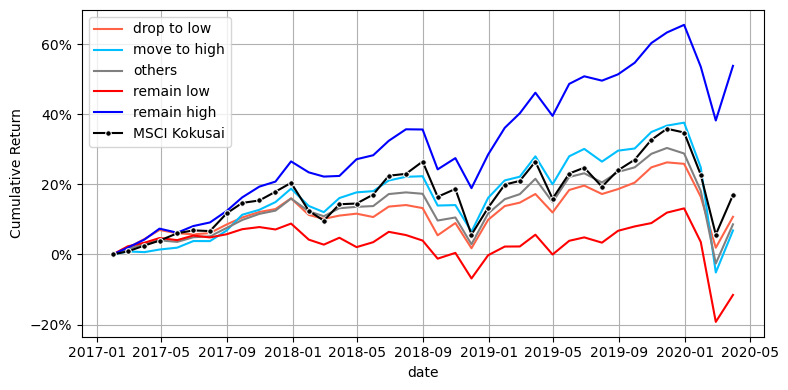

In [ ]:
df = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")
start_date = "2017-01-01"
df_cum_return = calculate_cumulative_return(
    df,
    roic_label_col="ROIC_Label_mon_5YForward",
    return_col="Rtn_1MForward",
    start_date=start_date,
    # end_date="2020-03-31",
)

date_list = [
    s for s in pd.to_datetime(df["date"]).dt.strftime("%Y-%m-%d").unique().tolist()
]
date_list_str = "(" + ",".join(f"'{s}'" for s in date_list) + ")"

db_handler = DBHandler(user_flg="default", db_environment="default")
query = f"""
SELECT IDX_ID, NENGAPPI_DT, IDX_VALUE
FROM TMA_ADMIN.TB_OTB422_INDEX_D
WHERE IDX_ID = 'GDDUKOK_WMRY'
AND NENGAPPI_DT IN {date_list_str}
"""
df_benchmark = (
    db_handler.write_to_pandas(sql=query)
    .rename(columns={"NENGAPPI_DT": "date", "IDX_VALUE": "MSCI Kokusai"})
    .reset_index(drop=True)
    .assign(
        ym=lambda row: row["date"].dt.year.astype(str)
        + row["date"].dt.month.astype(str).str.zfill(2)
    )
    .sort_values("date")
)

g = pd.DataFrame(df_benchmark.groupby("ym")["date"].max()).reset_index()
df_benchmark = (
    pd.merge(g, df_benchmark, on=["ym", "date"], how="left")
    .query(f"date>='{start_date}'")
    .assign(
        Rtn_M=lambda df: df["MSCI Kokusai"].pct_change(),
        Rtn_M_1MForward=lambda df: df["Rtn_M"].shift(-1),
        Index_cum_return=lambda df: (1 + df["Rtn_M_1MForward"]).cumprod() - 1,
    )
    .dropna(subset=["Rtn_M_1MForward"])
    .drop(columns=["ym"])
    .reset_index(drop=True)
)
df_benchmark["Index_cum_return"] = (
    df_benchmark["Index_cum_return"] - df_benchmark.loc[0, "Index_cum_return"]
)
# display(df_benchmark)

# merge
df_cum_return = pd.merge(
    df_cum_return,
    df_benchmark.set_index("date"),
    left_index=True,
    right_index=True,
    how="left",
)

plot_roic_label_cum_return(df_cum_return, show_benchmark=True)


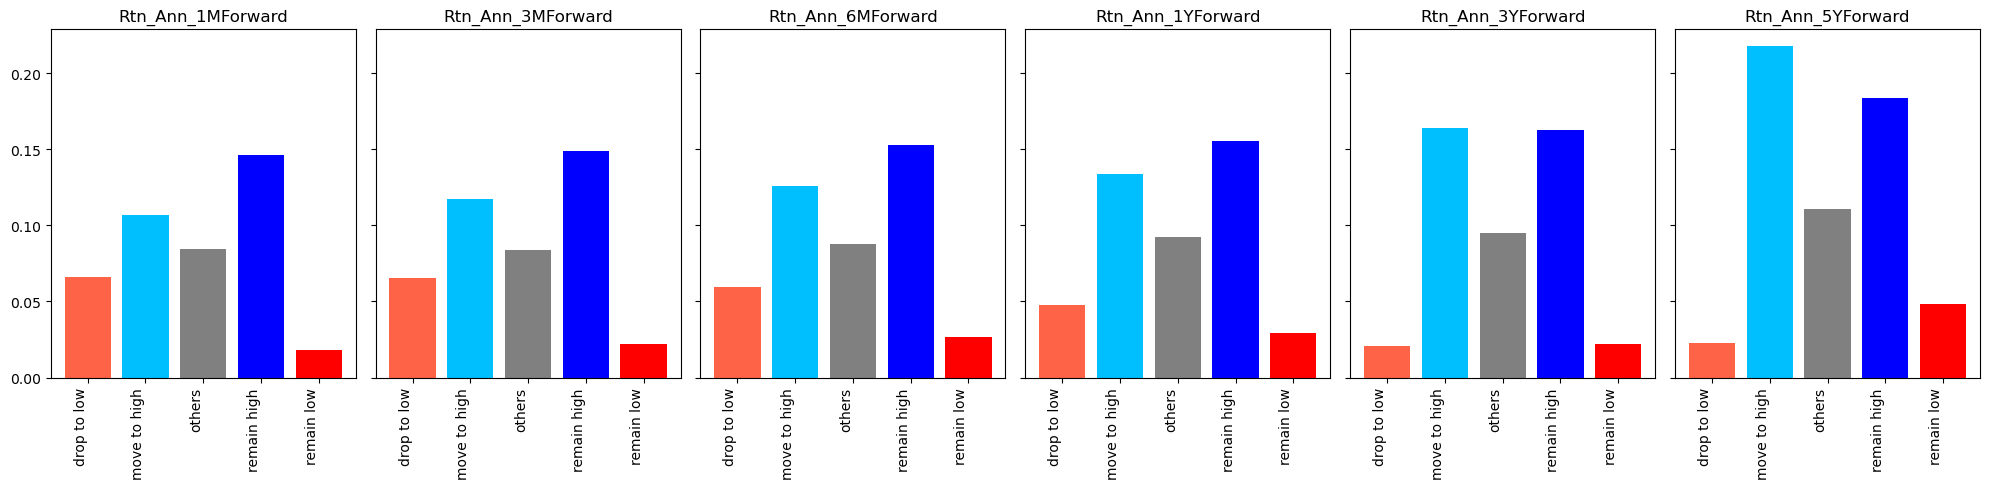

In [ ]:
df = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")
period = 5  # years
roic_col = f"ROIC_Label_mon_{period}YForward"
# roic_col = f"ROIC_Label_mon_5YForward"
# return_col = f"Rtn_Ann_{period}YForward"
return_col = "Rtn_Ann_3YForward"
# return_col = "Rtn_Ann_1MForward"
return_cols = [
    "Rtn_Ann_1MForward",
    "Rtn_Ann_3MForward",
    "Rtn_Ann_6MForward",
    "Rtn_Ann_1YForward",
    "Rtn_Ann_3YForward",
    "Rtn_Ann_5YForward",
]


# return_col = "Rtn_Ann_5YForward"
# g = pd.DataFrame(
#     df.groupby([roic_col])[return_col].apply(clipped_mean, percentile=5).reset_index(),
# )
# display(g)

# display(g_long)


# plot_period_return(df, period=period, roic_col=roic_col, return_col=return_col)


g_all = pd.DataFrame()
for i, return_col in enumerate(return_cols):
    g = pd.pivot(
        df.groupby(["date", roic_col])[return_col]
        .apply(clipped_mean, percentile=5)
        .reset_index(),
        index="date",
        columns=roic_col,
        values=return_col,
    )
    g_long = pd.melt(
        g.reset_index(), id_vars="date", value_vars=g.columns, var_name="ROIC_Label"
    ).rename(columns={"value": return_col})

    if i == 0:
        g_all = g_long
    else:
        g_all = pd.merge(g_all, g_long, on=["date", "ROIC_Label"], how="left")


# plot
fig, axes = plt.subplots(
    1, g_all.shape[1] - 2, figsize=(20, 5), sharey=True, tight_layout=True
)
color_setting1 = {
    "drop to low": "tomato",
    "move to high": "deepskyblue",
    "others": "grey",
    "remain high": "blue",
    "remain low": "red",
}
bar_colors = [
    color_setting1.get(label, "grey") for label in g_all["ROIC_Label"].unique()
]

for i, return_col in enumerate(g_all.columns[2:]):
    ax = axes[i]
    g_mean = g_all.groupby("ROIC_Label")[return_col].mean().reset_index()
    ax.set_title(return_col)
    ax.bar(g_mean["ROIC_Label"], g_mean[return_col], color=bar_colors)

fig.autofmt_xdate(rotation=90)
plt.show()


# ROIC Label Movement


In [ ]:
df = pd.read_parquet(DATA_DIR / "MSCI KOKUSAI_all data.parquet")
# df = df.loc[
#     (df["date"] == "2015-03-31") & (df["GICS_SECTOR"] == "Information Technology")
# ]

df = df.loc[(df["date"] == "2015-03-31")]

roic_label1 = "ROIC_Rank_1MForward"
roic_label2 = "ROIC_Rank_60MForward"
plot_sankey_diagram(df, roic_label1=roic_label1, roic_label2=roic_label2)
